# Imports

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import math
import seaborn as sns
import warnings
from scipy.stats import zscore
warnings.filterwarnings('ignore')

## Import custom functions for uploading/generating processed calcium, pupil, and behavioural metrics ##
try:
    import importlib
    importlib.reload(fn)
except NameError: # It hasn't been imported yet
    import functions_module as fn
    
## Import custom plotting function ##
try:
    import importlib
    importlib.reload(pulsar)
except NameError: # It hasn't been imported yet
    import pulsar_plots as pulsar

# Upload processed metrics from data repository #

In [59]:
## Define directory of data repository ##
data_directory = fn.set_data_directory(r'C:\Users\61407\Desktop\Current analysis\Project 3')

## Upload semi-processed calcium and pupil data of cohort, split into behaviorally-relevant epochs ##
cohort_epochs = fn.upload_cohort_epochs(data_directory)

## Upload fully processed calcium and pupil metrics ##
all_metrics = np.load(data_directory+'\\'+'all_metrics.npy', allow_pickle=True).item()

## Upload processed behavioural metrics ##
extracted_behavior = np.load(data_directory+'\\extracted_behavior.npy', allow_pickle=True).item()

## Look specifically at highly correlated thalamocortical bouton-dendrite pairs? ##

For each ROI – the “query ROI” – the Ca2+ events of this query ROI is compared against all other cross-channel ROIs in the same FOV (i.e. “comparison ROIs”). For each query-comparison pair, every Ca2+ event of the query ROI is compared against every Ca2+ event of the comparison ROI to detect “shared events” that occurred within a 500ms time window of each other (either 250ms before, or 250ms after). A shared event proportion is then calculated for each query-comparison pair as:
- *Proportion(query ROI) = N(shared events between query and comparison ROI) / N(total events for query ROI)*

The final metric used to measure a given query ROIs functional connectivity can be the maximum or mean shared event proportion across its pairwise comparisons with all comparison ROIs (i.e. the proportion of events it had with its most correlated comparison ROI). The following parameters can be set:
- ***pairwise_cutoff (float)***: Quantile cut-off of the correlation metric
- ***cutoff_on (str)***: Which summary value of the correlation metric that you want to use for the cutoff (i.e. quantile cutoff will be applied to this metric). This value can either be **'maxes'** or **'means'**
- ***display_plot (Bool)***: Whether you want to visualize the cutoff relative to the distribution of the correlation metric scores
- ***nbins (int)***: The number of bins you want to use to visualize the distribution

In [60]:
pairwise_cutoff = 0.9
cutoff_on = 'maxes'
display_plot = False
nbins = 20

In [61]:
## Upload the correlated ROI pairs metrics .npy file from data directory for the above parameter settings ##
correlated_ROIs = np.load(data_directory+'\\correlated_ROIs_'+str(rthresh)+'rthresh_'+str(time_thresh)+'timethresh_'+str(event_thresh)+'eventthresh.npy', allow_pickle=True).item()

## Apply new threshold ##
filtered_ROI_dfs = fn.filter_correlated_ROIs(correlated_ROIs, pairwise_cutoff, cutoff_on, nbins, display_plot)

## Return list of correlated ROIs ##
correlated_ROI_list = pd.concat(filtered_ROI_dfs).index.get_level_values(2).tolist()

# Visualize ROI-by-ROI, trial-by-trial activity of each FOV #
1. In order to visualize specific FOVs:
    - ***sessions (list or str):*** A list of strings defining the names of the FOVs you want to view (they will also be the figure titles). If the string **'all'** is passed, then all sessions will be plotted. Refer to the appendix (at the end of the notebook) to find the specific names of FOVs.
    - ***protocols (list):*** Once the sessions are defined, then you can further filter the FOVs plotted by limiting the plots to those during specific protocols. The different experimental protocols are Novice/Expert detection task **(Ndet/Edet)**, discrimination task **(Ndis/Edis)**, reversal task **(Nrev/Erev)**
    - ***channels (list):*** A list of strings defining which channel recordings you want to view. Dendritic FOVs are **'Red'** and boutonal FOVs are **'Green'**
<br>
<br>
2. In order to visualize specific trials:
    - ***trialtypes (list):*** A list of strings defining which trial types you want to view. Refer to the appendix (at the end of this notebook) to see the possible strings you can use
    - ***max_trials (int):*** If you want to limit the number of trial plotted
    - ***min_trials (int):*** If you want to limit the plots to FOVs that had at least **min_trials** number of trials for your trial types of interest
    - ***seeds (list):*** If using the max_trials and min_trials parameters, then trials are randomly sampled from the data. The seeds parameters helps with reproducibility/if you want to be able to select the same random sample again later. For this to work properly, the number of seeds (i.e. the length of this list) should be the same as the number of FOVs you want to plot.
<br>
<br>
3. To change the parameters of the visualizations themselves:
    - ***squish_factor (float):*** Allows you to increase how "squished" together the traces are, in the vertical axis. Minimum value is 1, otherwise the traces may not all fit on the figure.
    - ***y_shrinkage (float):*** Allows you to decrease the figure size by this factor in the y-axis, without squishing together the traces (i.e. the traces themselves will just get smaller)
    - ***x_range (list):*** List of floats that allows you to visualize a specific time window of a trial, starting at the first element of the list, and ending in the second element of the list (in seconds).
    - ***scaling_dict (dict):*** A dictionary that allows you to completely scale the figure in both the x and y axis by a factor of **'x_scaling'** in the x-axis, and **'y_scaling'** in the y-axis. Think of this as the "master" scaling parameter that you apply after you are happy with the way the traces look, but need to change the size of the figure to fit in a specifically-sized figure panel, for example.
<br>
<br>
4. To sort the order of the traces using ***sort_dict (dict)***:
    - ***sort_by (list):*** A list of strings defining which metrics you want to sort the traces by. Sort by the number of events within your epoch of interest (i.e. **'nEvents'**) or the peak amplitude of the trace (i.e. **'peak'**). The first metric in the list will take priority in the ordering process.
    - ***ascending (list):*** A list of Booleans defining if you want to sort the traces in ascending (i.e. **True**) or descending (i.e. **False**) order, for each ordering metric.
    - ***events_first (Bool):*** Whether you want to plot the events first at the top of the pulsar (i.e. **True**) or at the bottom (i.e. **False**)
    
5. Some final parameters:
    - ***ROIs ('str'):*** A string stating which ROI sub-population you want to extract traces from. Either view all ROIs (i.e. **'all'**) or only correlated bouton-dendrite pairs (i.e. **'correlated'**) as defined in the previous section
    - ***save (Bool):*** Whether you want to save the resulting figures (i.e. **True**) or not (i.e. **False**)

In [67]:
sessions = ['Edis_230103_FOV2.2','Nrev_221105_FOV3.1','Erev_230105_FOV2']
protocols = ['Edis','Nrev','Erev']
channels = ['Green','Red']

trialtypes = ['responses','no responses']
max_trials = 5
min_trials = 5
seeds = [0,0,0]

squish_factor = 2
y_shrinkage = 2 
x_range = [3,7]
scaling_dict = {'xscaling':1,
                'yscaling':1}

sort_dict = {'sort_by':['nEvents','peak'],
             'ascending':[False, False],
             'events_first':False}

ROIs = 'all'
save = False

**Time to visualize! Just a couple points on interpreting the visualizations:**
1. Each trace is a single trial from a single FOV. All traces are plotted together for one FOV in one figure, with the figure title at the top, and the trial number at the bottom of each subplot column. Each row is a single ROI in the FOV, and the ordering of ROIs is not the same across multiple trials/subplot columns (due to the ordering of traces based on activity).
2. Coloured traces show when a trace had an event during the epoch of interest
3. Vertical lines overlaid on top of the traces show when specific behavioural events occurred (red = stimulus onset, orange = lick onset, blue = reward onset). Depending on your ***x_range*** parameter, these vertical lines may or may not show up on the plot. Refer to appendix (at the end of this notebook) on behavioural event timings across a trial

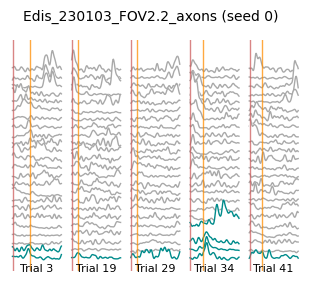

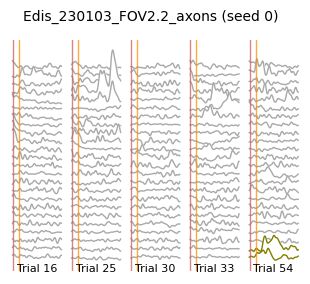

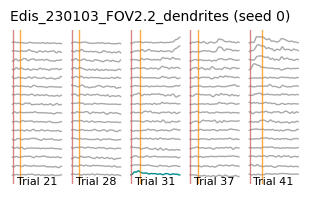

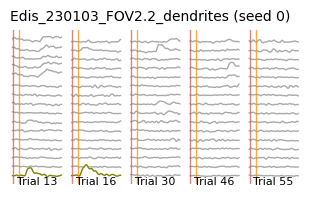

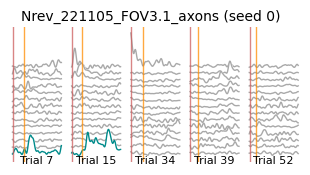

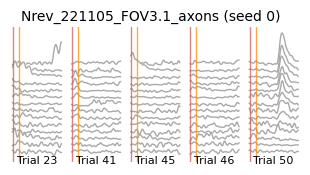

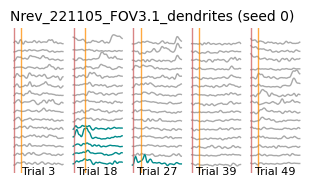

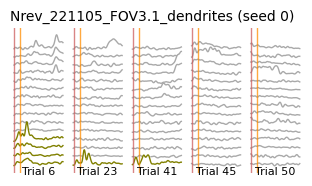

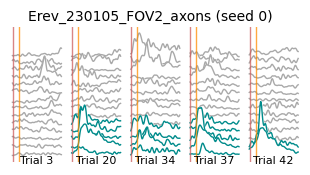

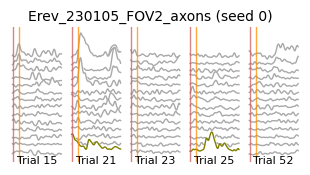

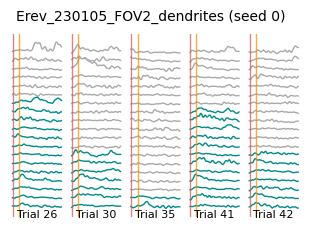

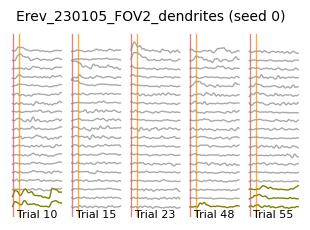

In [70]:
## First extract data from sub-population of interest (or not) ##
deltaF_ROIs, events_ROIs = pulsar.filter_ROIs(cohort_epochs, 'all', ROIs, correlated_ROI_list)

## Run the pulsar plot function with the parameters defined in the previous cell ##
pulsar.plot_all_pulsar_traces(sessions, seeds, protocols, trialtypes, channels, 
                              max_trials, min_trials, 
                              squish_factor, y_shrinkage, x_range, 
                              scaling_dict, sort_dict,
                              deltaF_ROIs, events_ROIs, cohort_epochs, correlated_ROI_list, ROIs,
                              save)

# Appendix #

Below is a dataframe called  **FOV_df**, showing all of the FOVs that were recorded from (and their associated mouse ID, protocol code, and recording channel)

In [96]:
all_df = pd.concat(cohort_epochs['deltaF']['all'])
means = all_df.groupby([all_df.index.get_level_values(0),
                        all_df.index.get_level_values('Protocol'),
                        all_df.index.get_level_values('Unique session'),
                        all_df.index.get_level_values('Channel')]).mean()
FOV_df = means.reset_index().iloc[:,:4]
FOV_df.columns = ['mouse ID','protocol code','FOV name','recording channel']
FOV_df

,mouse ID,protocol code,FOV name,recording channel
0,GCaMP_POm_Batch3_five,Edet,Edet_220602_FOV1,Green
1,GCaMP_POm_Batch3_five,Edet,Edet_220602_FOV2,Green
2,GCaMP_POm_Batch3_five,Edet,Edet_220603_FOV1.1,Green
3,GCaMP_POm_Batch3_five,Edet,Edet_220603_FOV2.1,Green
4,GCaMP_POm_Batch3_five,Edet,Edet_220603_FOV2.2,Green
...,...,...,...,...
94,RGECO_GCamP_Batch3_three,Erev,Erev_230105_FOV2.1,Green
95,RGECO_GCamP_Batch3_three,Ndet,Ndet_221229_FOV2.1,Green
96,RGECO_GCamP_Batch3_three,Ndet,Ndet_221229_FOV2.2,Green
97,RGECO_GCamP_Batch3_three,Ndis,Ndis_230101_FOV2.NDIS,Green


In the Go/NoGO task trial types are defined as follows:
- **'hit'** is defined as a correct response to the Go stimulus
- **'miss'** is defined as an incorrect failure to respond to the Go stimulus
- **'FA'** is defined as incorrect response to the NoGo stimulus
- **'CR'** is defined as the correct withholding of a response to the NoGo stimulus

Each of these trial types can be further broken down into **'rewarded'** trials or **'unrewarded'** trials. The key in the dictionary below allows you to access the trialtypes in the corresponding list. For example, if you pass **'correct responses'** to a function that requires you to pass trial types of interest, then it will select data from **'rewarded hit'** trials and **'unrewarded hit'** trials

In [ ]:
all_trialtypes = {'correct responses': ['rewarded hit', 'unrewarded hit'],
                 'incorrect responses': ['rewarded FA', 'unrewarded FA'],
                 'unexpected omission': ['unrewarded hit', 'unrewarded hit'],
                 'expected omission': ['unrewarded FA', 'unrewarded FA'],
                 'expected reward': ['rewarded hit', 'rewarded hit'],
                 'unexpected reward': ['rewarded FA', 'rewarded FA'],
                 'unexpected outcomes': ['unrewarded hit', 'rewarded FA'],
                 'expected outcomes': ['unrewarded FA', 'rewarded hit'],
                 'responses':['rewarded hit','rewarded FA','unrewarded hit','unrewarded FA'],
                 'no responses':['unrewarded miss','unrewarded CR'],
                 'rewarded responses':['rewarded hit','rewarded FA'],
                 'unrewarded responses':['unrewarded hit','unrewarded FA']}

Recordings are all 12 seconds in duration for each trial. After a 3-second baseline period, the **stimulus is always delivered at t=3s**. The mice then have a **1-second time window to respond (i.e. before t=4s)**. If there is a response within this time window, then **feedback is given to the mice exactly 1 second after this response time**. Feedback may either be positive (i.e. reward) or negative (i.e. no reward).